# Comparison between DLC and Sleap


Sleap provides a couple of small videos at the [sleap repo under the test data folder](https://github.com/talmolab/sleap/tree/develop/tests/data/videos), as well as a sample video from the [sleap datasets repo](https://github.com/talmolab/sleap-datasets) that is more refined and also contains some labels. DeepLabCut provides example videos in their [git repo](https://github.com/DeepLabCut/DeepLabCut/tree/main/examples). For this comparison, we will be using the [example mice video](https://github.com/DeepLabCut/DeepLabCut/blob/main/examples/Reaching-Mackenzie-2018-08-30/videos/reachingvideo1.avi) for this comparison. 

Comparison pipeline: skip prediction-assisted labeling

- Generate some frames to label, train on 80% and test on 20% 
- Train model
- Predict on entire video

Evaluation metrics:

- Pixel error on test labeled frames
- Visualize Predictions Labeled video

This notebook records the DLC details where as the [Compare SLEAP notebook](./Compare-Sleap.ipynb) records the SLEAP details. 

### Table of contents

- [DLC Overview](#DLC-Overview)
- [Demo: DLC pipeline](#DLC-PIPELINE)
- [Comparison: DLC Training with imported DLC labels](#DLC-TRAINING-with-imported-DLC-data)

In [ ]:
import deeplabcut
import pandas as pd
import numpy as np
from pathlib import Path

NOTEBOOK_DIR = Path.cwd()
DLC_PROJECT_DIR = NOTEBOOK_DIR / "dlc-prelabeled-Pranav-2023-07-27"

# DLC Overview

The [DeepLabCut](https://www.nature.com/articles/s41596-019-0176-0.epdf?author_access_token=YdgZNNupsH23JNKsogan2tRgN0jAjWel9jnR3ZoTv0PafSJfogKvzMN9Yibs0_Cn5RrZDjtijUWL61FeNFC2vYig0gH-hrXbchDCvAxDsQhlBRStoRflJdbJePPUfES7jig_npStoBnzkKR817z8Tw%3D%3D) paper provides an overview of the workflow. It mentions that DeepLabCut uses deep, residual networks with either 50 or 101 layers (ResNets) and deconvolutional layers, whereas LEAP (predecessor of SLEAP) uses 15-layer convolutional network. DeepLabCut uses pre-trained networks and benefits from transfer learning, whereas LEAP trains from scratch hence may be faster. 

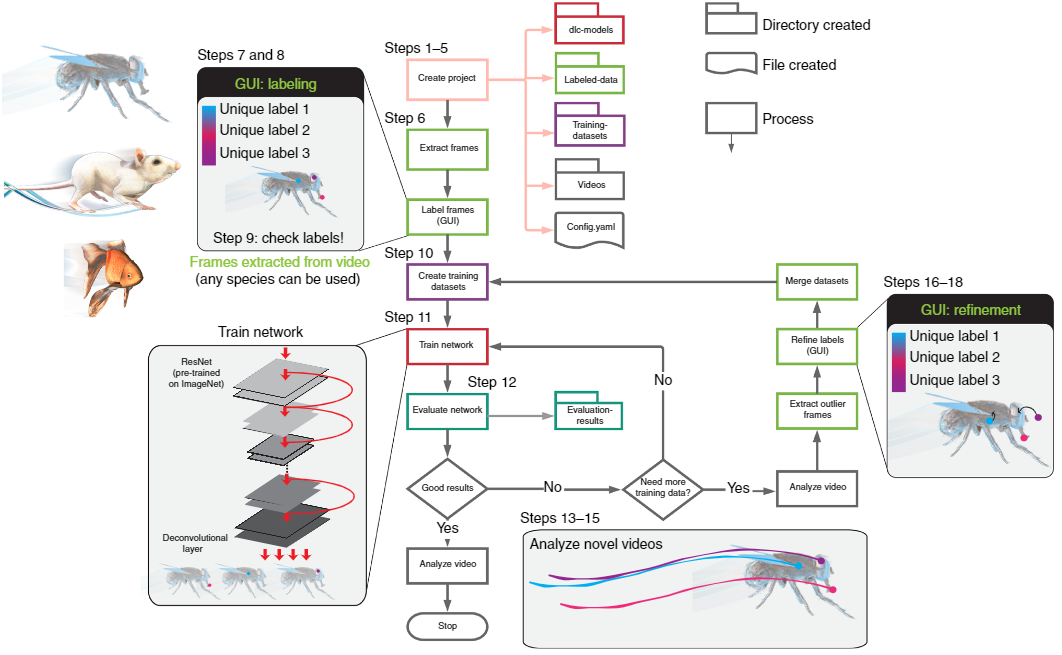

### Some notes on DLC evaluation

For single-animal DLC project, you may generate different shuffles of training datasets to perform cross validation. The only model metric available is the mean average Euclidean error (MAE, proportional to root mean square error). There are train and test errors for each shuffle, as well as train and test errors for predictions above a `p-cutoff` condition. 

For a multi-animal DLC project, there is a function to perform [cross-validation](https://github.com/DeepLabCut/DeepLabCut/blob/0e5380bb04d49a7ab97427c0d15173bb88c7559a/docs/functionDetails.md#cross-validation-of-inference-parameters-a-madeeplabcut-critical-point) on the inference parameters before tracking. There are more metrics generated, for example the root mean square error (RMSE), number of hits and misses, the percentage of correct keypoints (PCK), and false positives. You could examine its [implementation code here](https://github.com/DeepLabCut/DeepLabCut/blob/52080cda5f7ea8e92fa43d8cf5cb2e6e9a42ca07/deeplabcut/pose_estimation_tensorflow/lib/crossvalutils.py#L170) or look at a short explanation of the metrics in [this post](https://forum.image.sc/t/general-question-deeplabcut-evaluation-output/44437/4). Similar metrics are also computed by SLEAP, but SLEAP computes more metrics not provided by DLC sucha s object keypoint similarity (OKS), which is a common pose estimation metric. 

## DLC PIPELINE

### Some preliminary notes on DLC

The default directory for DLC projects is the User Desktop. You may create the project on the Desktop, and copy the folder to the Home Folder before creating the training datasets. Alternatively, you may create the project in the Home Folder as shown below.

Open a python session in terminal by typing `python` in the DEEPLABCUT environment, then run the following commands: 

    import deeplabcut
    deeplabcut.create_new_project('dlc-prelabeled','louise', ['C://s3-mount//dlc-sample-videos//mouse-movement-videos//mouse-top-view.mp4'], working_directory='C://Users//PhotonUser//My Files//Home Folder',copy_videos=False)
    
This will create the project `dlc-prelabeled-louise-2023-07-31` folder inside Home Folder. More details on deeplabcut functions are available at the [functiondetails documentation](https://github.com/DeepLabCut/DeepLabCut/blob/53a784b95a0d31b403deab0541b4770fd001448f/docs/functionDetails.md), or use the python help function to see the function documentations. 

If you ran create training datasets before copying the files to the Home Folder, the training data will contain the paths to the original Desktop location. Suppose you open an AppStream session the next day and try to start training the network, you will notice errors because the files on the Desktop would be cleared.The underlying Desktop path would also be different, so if you try to copy the files in Home Folder back onto the Desktop, the error would still persist. However, you can fix this by going to the `create training dataset` tab and run that again. This will update the training data path to the path in Home Folder, and you can continue training the network successfully. 

### Label frames and Train model

In `config.yaml` specify the body parts, skeleton, and change the training fraction to `0.8`. Other attributes you might want to change:

    - `point size`: controls the size of the labeling marks
    - `pcutoff`: controls the confidence / likelihood cutoff level that DLC uses to filter out predictions, e.g. before creating the video or when generating model metrics

Label frames in the Napari pop-up window, then save selected layer to create a `CollectedData_louise.csv` file and `.h5` file in the `labeled-data` folder containing the label coordinates. 

After labeling the extracted frames, `create training dataset` will combine the labeled datasets from all the videos (only one video for our comparison purpose) under the `training-dataset` folder. Note that you may create multiple separate training datasets by changing the shuffle number. 

Before training the network, you can modify the training parameters in the GUI directory or in the `dlc-models\iteration0\train\pose_cfg.yaml`. Then click train network to begin training, which creates a train and test folder under `dlc-models` folder. 

- It is recommended to train the networks for thousands of iterations until the loss plateaus (typically around 500,000) if you use batch size 1, and 50-100K if you use batchsize 8 (the default).
- The variables `display_iters` and `save_iters` in the pose_cfg.yaml file allows the user to alter how often the loss is displayed and how often the weights are stored.

### Evaluate model performance

Evaluate trained network will compute performance metrics such as train and test errors (**evaluation metric 1**, available in `CombinedEvaluationResults` file) by comparing manual labels and predicted labels. They will be saved in the `evaluation-results` folder. 

If you click the `Plot 3 test maps` button, this will create some images in the `evaluation-results/iteration-0/dlc-testJul25-trainset80shuffle1/maps/` folder. 

### Predict on entire video

Finally, you can use the network to analyze new videos (or the same video in this comparison). The prediction coordinates and likelihoods will be saved as an `.csv` file under the same directory as the video file (along with an H5 file and a PICKLE file). If you select the `plot trajectories` option in the GUI, it will create a `plot-poses` folder in the directory of the video, and it will contain some trajectory plots such as coordinates of body parts vs. time, likelihoods vs time.

**Ideally you would only do this after you are done with prediction-assisted labeling and are satitsfied with your model performance**

### (Optional) Prediction-assisted labeling

Extract outlier frames will extract 20 more frames in `labeled-data` along with a `machinelabels.csv` and `machinelabels-iter0.h5` file. Click `Labeling GUI` to refine labels, note that only the extracted outlier frames will be editable, the previously labeled frames that were used for training will not be editable. After saving, click `Merge Data`. This will update the `labeled-data/CollectedData_louise.csv` file to include the refined labels as well. 

Now go back to the `Create training dataset` tab to create a new training dataset under the `training-datasets/iteration-1/` folder. Repeat the training and evaluation process until you are satisfied, then create predictions on the entire video. 

### Create Labeled Video

You can also create labeled videos (**evaluation metric 2**, under `videos\mouse-top-viewDLC_resnet50_dlc-mouse-topviewJul24shuffle1_20_labeled.mp4`). Click `Build skeleton` first to join nodes, then click `Create videos` to create a video with the skeleton drawn. Remember that skeleton configurations in the `config.yaml` file control what the skeleton should look like. 


P.S. Suppose you modify the something in the config.yaml file like skeleton color, and would like to create a new prediction video. The GUI will not process because it detects that a video file with the default filename already exists (selecting overwrite videos option doesn't help). If you want to create multiple prediction videos, rename the existing video files to another name, then click `create video` to create a new video file with the same default filename. 


## DLC TRAINING with imported DLC data

In order to use the imported data from github, the image file paths and the experimenter name must match. You could modify the imported csv, but for simplicity, I just created a project where Pranav is the experimenter, renamed my `labeled-data/mouse-top-view/` folder into `labeled-data/m4s1/` and moved the contents in the github labeled-data directory into the renamed directory. Remember to modify the config.yaml file, most importantly the training fraction and the bodyparts. Then you can continue with creating training datasets as demonstrated in [DLC PIPELINE](#DLC-PIPELINE). 


You may also use the deeplabcut function to change the experimenter name. However, it does not modify the image file paths, so you must still ensure that the file paths match up. First, rename `labeled-data/mouse-top-view/` folder into `labeled-data/m4s1/` and moved the contents in the github labeled-data directory into the renamed directory. Then, rename `videos/mouse-top-view.mp4` into `videos/m4s1.mp4`. Finally, update the video file name in the in the config.yaml file `video_sets` section. Then run the following command in a python session:

    deeplabcut.convertcsv2h5('C:\\ProgramData\\UserDataFolders\\S-1-5-21-3098806350-513340488-2980939788-1012\\My Files\\Home Folder\\dlc-prelabeled-louise-2023-07-31\\config.yaml', scorer="YOURNAME")

### Train Results

Default DLC pipeline with 100,000 iterations: ran for 3h, on average 1-2 min per 1000 iterations. (Check out the `train/log.txt` file under `dlc-models` for this timing information)

In [4]:
TRAIN_MODEL_DIR = DLC_PROJECT_DIR / "dlc-models" / "iteration-0" / "dlc-prelabeledJul27-trainset80shuffle1" / "train"
LOG_FILE = TRAIN_MODEL_DIR / "log.txt"
!more $LOG_FILE

2023-07-27 22:08:11 Config:
{'all_joints': [[0], [1], [2], [3]],
 'all_joints_names': ['snout', 'leftear', 'rightear', 'tailbase'],
 'alpha_r': 0.02,
 'apply_prob': 0.5,
 'batch_size': 1,
 'contrast': {'clahe': True,
              'claheratio': 0.1,
              'histeq': True,
              'histeqratio': 0.1},
 'convolution': {'edge': False,
                 'emboss': {'alpha': [0.0, 1.0], 'strength': [0.5, 1.5]},
                 'embossratio': 0.1,
                 'sharpen': False,
                 'sharpenratio': 0.3},
 'crop_pad': 0,
 'cropratio': 0.4,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_dlc-prelabeledJul27\\dlc-prelabeled_Pranav80shuffle1.mat',
 'dataset_type': 'imgaug',
 'decay_steps': 30000,
 'deterministic': False,
 'display_iters': 1000,
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'init_weights': 'C:\\miniconda3\\envs\\DEEPLABCUT\\lib\\site-packages\\deeplabcut\\pose_estimation_tensorflow\\models\\pretrained\\resnet_v1_50.ckpt',
 'intermediate_

### Evaluation Results

In [56]:
EVAL_DIR = DLC_PROJECT_DIR / "evaluation-results" / "iteration-0"
dlc_results = pd.read_csv(str(EVAL_DIR / "CombinedEvaluation-results.csv" ))
dlc_test_error = dlc_results.iloc[0,-1]
print("test pixel error: ", dlc_test_error)
dlc_results

test pixel error:  3.44


Unnamed: 0  Training iterations:  %Training dataset  Shuffle number  \
0           0                100000                 80               1   

    Train error(px)   Test error(px)  p-cutoff used  \
0              2.24             3.44            0.6   

   Train error with p-cutoff  Test error with p-cutoff  
0                       2.24                      3.44

### Summarize Comparison results

If this is your first time summarizing the comparison results in to a .csv file, run the first code block to create the dataframe.

In [59]:
# results = np.array([None, None, dlc_test_error])
# results_df = pd.DataFrame([results], columns=["sleap (single basline)", "sleap (single pretrained)", "dlc" ], index=["test error (px)"])
# results_df.to_csv("comparison_results.csv")
# results_df

sleap (single basline) sleap (single pretrained)   dlc
test error (px)                   None                      None  3.44

If you ran the SLEAP notebook before and have already saved the comparison results to a .csv file, run this second code block to load the file contents and update the dlc error.

In [60]:
results_df = pd.read_csv("comparison_results.csv", index_col=[0])
results_df.iloc[0,2] = dlc_results.iloc[0,-1]
results_df.to_csv("comparison_results.csv")
results_df

sleap (single basline)  sleap (single pretrained)   dlc
test error (px)                1.964048                   2.206364  3.44

# Format DLC predictions for Sleap evaluation and visualization (in progress)

Either evaluate separately, or import DLC predictions into Sleap to evaluate model and visualize result. 

Import Predictions CSV error: ValueError: Skeleton already has a node named (head)

- Possible reason: csv has extra column likelihood
- Solution: try to export csv in dlc in previous format

## Format Sleap Predictions for DLC Visualiztaion (blocked)

ISSUE: Cannot extract the labeled images file from .slp file, but DLC csv needs those paths and image files. 

In [2]:
import h5py
import matplotlib.pyplot as plt

filename = "C:/Users/louise.xu/Downloads/mouse-labels.h5" # or your own exported filename

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

    print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations (tracks) data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===filename===
C:/Users/louise.xu/Downloads/mouse-labels.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations (tracks) data shape===
(2330, 2, 2, 1)

===nodes===
0: head
1: tailBase



Need to formate csv into dlc acceptable format as instructed [here](https://github.com/DeepLabCut/DeepLabCut/wiki/Using-labeled-data-in-DeepLabCut-that-was-annotated-elsewhere-(or-merge-across-labelers))

In [98]:
import numpy as np
import pandas as pd
locations = locations.reshape((2330, 4))

bodyparts = []
coords = []
scorer = []
scorer_name = "louise"
for name in node_names:
    bodyparts += [name]*2
    coords += ["x"]
    coords += ["y"]
    scorer += [scorer_name]*2

def convert_df (arr):
    return pd.DataFrame(np.array([arr]))

df = pd.DataFrame(locations)

df = pd.concat([convert_df(bodyparts), convert_df(coords), df])
df.columns = scorer
df
#np.savetxt("C:/Users/louise.xu/Downloads/sleap-mouse-predictions.csv", locations_csv, delimiter=",", header=header, comments="")

louise      louise      louise      louise
0           head        head    tailBase    tailBase
0              x           y           x           y
0      76.977142   88.586418  140.419189  187.721466
1      76.211014     87.9543  140.592499  180.707001
2      75.789993   84.666412  143.833466  176.909729
...          ...         ...         ...         ...
2325  347.900238  380.163879  424.336731  443.984863
2326   349.19101  380.117371  428.229675  443.702759
2327  352.273102  380.147186   428.39679  443.756714
2328  356.354065  380.305115   432.69458  440.235352
2329   356.47879  380.162567  435.873352  439.975952

[2332 rows x 4 columns]

In [3]:
import deeplabcut
help(deeplabcut.create_labeled_video)
#%cd C:\Users\louise.xu\projects\Deeplabcut\examples\openfield-Pranav-2018-10-30
#deeplabcut.create_labeled_video('config.yaml', ['./videos/m3v1mp4.mp4'])

Help on function create_labeled_video in module deeplabcut.utils.make_labeled_video:

create_labeled_video(config, videos, videotype='', shuffle=1, trainingsetindex=0, filtered=False, fastmode=True, save_frames=False, keypoints_only=False, Frames2plot=None, displayedbodyparts='all', displayedindividuals='all', codec='mp4v', outputframerate=None, destfolder=None, draw_skeleton=False, trailpoints=0, displaycropped=False, color_by='bodypart', modelprefix='', init_weights='', track_method='', superanimal_name='', pcutoff=0.6, skeleton=[], skeleton_color='white', dotsize=8, colormap='rainbow', alphavalue=0.5, overwrite=False)
    Labels the bodyparts in a video.
    
    Make sure the video is already analyzed by the function
    ``deeplabcut.analyze_videos``.
    
    Parameters
    ----------
    config : string
        Full path of the config.yaml file.
    
    videos : list[str]
        A list of strings containing the full paths to videos for analysis or a path
        to the director